In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torchvision
from torchvision import transforms
import cv2
import math

from collections import Counter
from PIL import Image
import PIL

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as fun

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()
from nltk.tokenize import word_tokenize

import match
import pickle
import gc
import random

**Data Preprocessing**

In [27]:
data = pd.read_csv("captions.txt", sep=',')

#Removes Single Char
def remove_single_char(caption_list):
    list = []
    for word in caption_list:
        if len(word)>1:
            list.append(word)
    return list

#Make an array of words out of caption and then remove useless single char words

data['caption'] = data['caption'].apply(lambda caption :word_tokenize(caption))

data['caption'] = data['caption'].apply(lambda word : remove_single_char(word))

#We need to make sure size of all the captions arrays is same so we add <cell> to cover up
lengths = []
lengths = data['caption'].apply(lambda caption : len(caption))

max_length = lengths.max()

data['caption'] = data['caption'].apply(lambda caption : ['<start>'] + caption + ['<cell>']*(max_length-len(caption)) + ['<end>'])

#For non truncated dataframe to appear
pd.set_option('display.max_colwidth', None)

print(max_length)

#Extracting words 
words = data['caption'].apply(lambda word : " ".join(word)).str.cat(sep = ' ').split(' ')

#Arranging the words in order of their frequency
word_dict = sorted(Counter(words), key=Counter(words).get, reverse=True)

dict_size = len(word_dict)
vocab_threshold = 5

#Encoding the words with index in dictionary made above
data['sequence'] = data['caption'].apply(lambda caption : [word_dict.index(word) for word in caption])
data = data.sort_values(by = 'image')

32


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Image Captioning Model**

In [29]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=(max_length+2)):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [30]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()
        self.n_head = n_head

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        # display(decoder_inp)
        encoded_image = encoded_image.permute(1,0,2)

        decoder_inp = torch.clamp(decoder_inp, 0, self.embedding.num_embeddings - 1)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        decoder_inp_embed = self.embedding(decoder_inp)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        
        
        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        
        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

In [31]:
model = pd.read_pickle('ImageCaptioning_Model.pkl')
start_token = 2
end_token = 3
cell_token = 1
max_seq_len = 34

In [32]:
validation = pd.read_pickle('Image_Features_Embed_ResNet_Valid.pkl')

**Generating Caption***

In [33]:
def generate_caption(K, image_path): 

    model.eval() 

    image = Image.open('Images/' + image_path).convert("RGB")
    plt.imshow(image)
    valid_img_df = validation[validation['image']==image_path]
    
    print("Actual Caption : ")
    actual_caption_list = valid_img_df['caption'].tolist()
    filtered_caption_list = [word for word in actual_caption_list[0] if word not in ['<start>', '<end>', '<cell>']]
    actual_caption = " ".join(filtered_caption_list)
    print(actual_caption)

    valid_img_embed = validation[validation['image'] == image_path]
        
    img_embed = valid_img_embed['embedded'].tolist()

    img_embed = torch.tensor(img_embed)


    input_seq = [cell_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0)
    predicted_sentence = []
    
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):
            img_embed_dense = img_embed.to_dense()

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            index_to_word = {index: word for index, word in enumerate(word_dict)}
            next_word = index_to_word[next_word_index]

            if eval_iter + 1 < max_seq_len:
                input_seq[:, eval_iter + 1] = next_word_index

            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    
    print("\n")
    print("Predicted caption : ")

    filtered_caption_list = [word for word in predicted_sentence if word not in ['<start>', '<end>', '<cell>']]
    print(" ".join(filtered_caption_list))

Actual Caption : 
man in red shirt climbs sheer cliff face over the tree tops


Predicted caption : 
man in red shirt is climbing rock rock


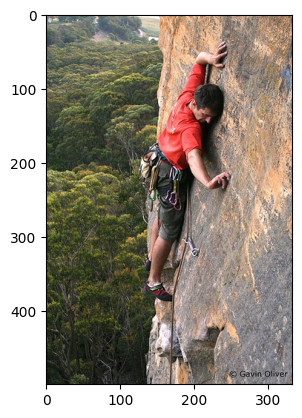

In [60]:
random_row = validation.sample()
random_image = random_row.iloc[0]['image']

generate_caption(1, random_image)

Actual Caption : 
surfer in black wetsuit rides wave


Predicted caption : 
man in black shirt is jumping in the water with his kayak in water in the water water in the water


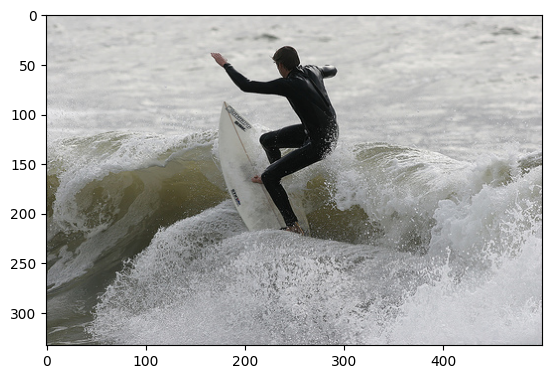

In [71]:
random_row = validation.sample()
random_image = random_row.iloc[0]['image']

generate_caption(2, random_image)

Actual Caption : 
white motorcycle is being jumped in the air by person in white outfit and crash helmet


Predicted caption : 
biker is riding bike on dirt track


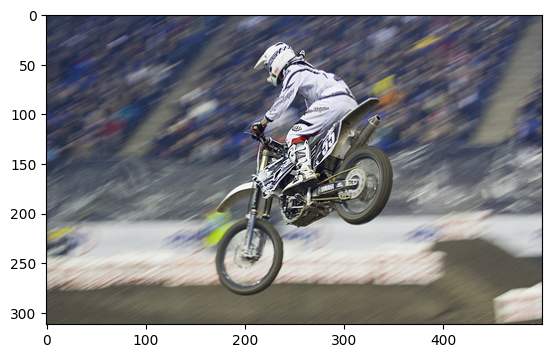

In [72]:
random_row = validation.sample()
random_image = random_row.iloc[0]['image']

generate_caption(1, random_image)